## Assignment 1
Mohammad Rashiqul Alam
malam25@illinois.edu

In [70]:
# Modules
import os
import numpy as np
import matplotlib.pyplot as plt
from   PIL import Image


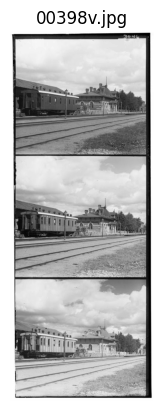

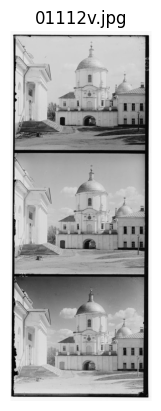

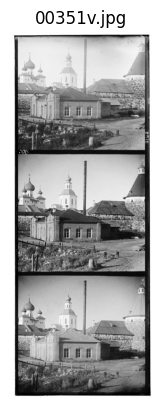

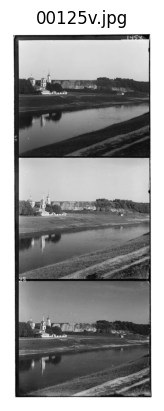

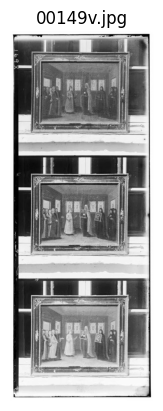

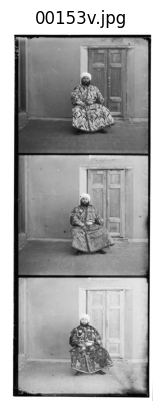

In [71]:
# Load images from directory
directory   = "/home/rashiqul/workspace/ece549/picture/data/"
image_files = [file for file in os.listdir(directory) if file.lower().endswith('.jpg')]

# Display aa 6 images
for file in image_files:
    path  = os.path.join(directory, file)
    image = Image.open(path)
    plt.imshow(image, cmap='gray')
    plt.title(file)
    plt.axis('off')
    plt.show()

# Image Cropping

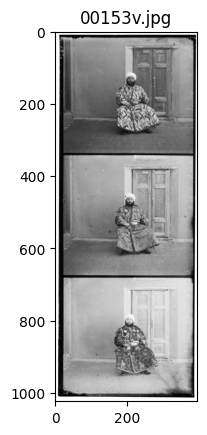

In [87]:
# Let's work with the first image in the list
image_path = os.path.join(directory, image_files[0])
image0 = Image.open(path)
plt.imshow(image0, cmap='gray')
plt.title(file)
plt.show()

In [88]:
# Normalize the image to [0, 1] range and display it
image0 = np.array(image0) / 255.0

# Print the image dimension, size and the matrix
print(f"Image dimensions: {image0.shape}")
print(f"Image size: {image0.size}")
print(f"Image matrix:\n{image0}")

Image dimensions: (1024, 394)
Image size: 403456
Image matrix:
[[0.99607843 0.99607843 0.99607843 ... 0.99607843 1.         1.        ]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 1.         1.        ]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 1.         1.        ]
 ...
 [1.         1.         1.         ... 0.99607843 1.         0.60392157]
 [1.         1.         1.         ... 0.99607843 1.         0.59215686]
 [1.         1.         1.         ... 0.99607843 1.         0.58431373]]


In [89]:
# Calculate the height of the image
height = image0.shape[0]
# Calculate the height per channel
height_per_channel = int(height / 3)

# Print the height per channel
print(f"Height per channel: {height_per_channel}") 

Height per channel: 341


In [90]:
# Slice the image into its three color channels using the calculated height_per_channel
top_slice_channel     = image0[0 : height_per_channel, :]
middle_slice_channel  = image0[height_per_channel : 2 * height_per_channel, :]
bottom_slice_channel  = image0[2 * height_per_channel : 3 * height_per_channel, :]

Top Dimension: (341, 394)


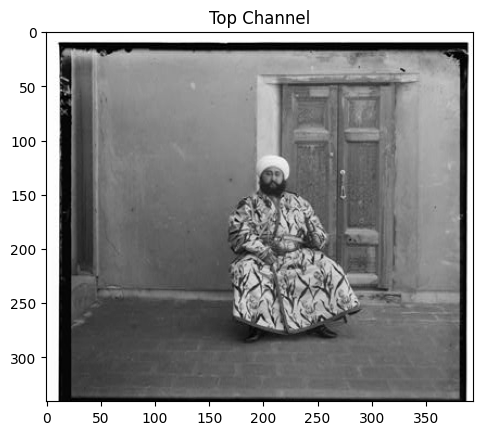

Middle Dimension: (341, 394)


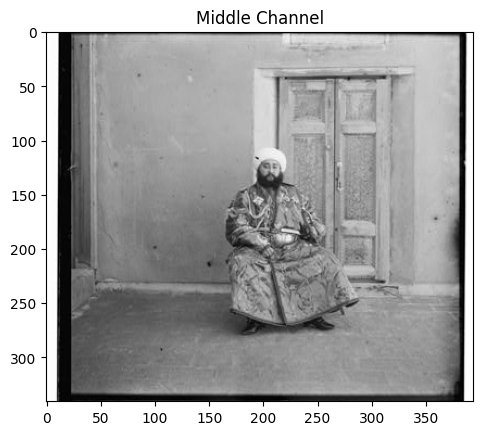

Bottom Dimension: (341, 394)


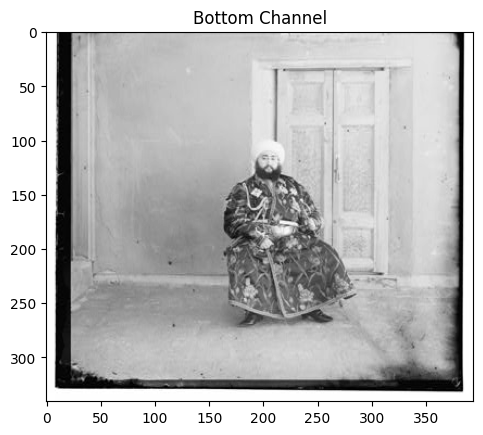

In [91]:
# Display the channels
for channel, slice in zip([top_slice_channel, middle_slice_channel, bottom_slice_channel], ['Top', 'Middle', 'Bottom']):
    plt.imshow(channel, cmap='gray')
    plt.title(f"{slice} Channel")
    print(f"{slice} Dimension: {channel.shape}")
    plt.show()

In [92]:
# Borders and clean-up
# There are black borders at the very top, bottom, left, and right of the image.
# These borders can be removed by slicing the image appropriately.
# Let's assume the borders are 8% wide on each side (taking a number in between 5-10%).

def remove_borders(channel, border_percent=0.08):
    """
    Function to remove borders from a given channel.
    """
    height, width = channel.shape
    # Get border sizes 
    top     = int(height * border_percent)
    bottom  = int(height * (1 - border_percent))
    left    = int(width * border_percent)
    right   = int(width * (1 - border_percent))
    # Crop the channel
    cropped = channel[top:bottom, left:right]
    
    return cropped


Top Dimension after border removal on white canvas: (286, 331)


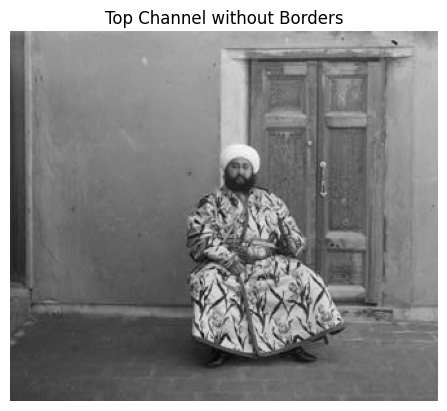

Middle Dimension after border removal on white canvas: (286, 331)


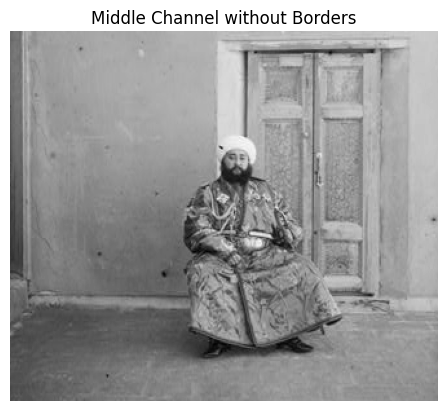

Bottom Dimension after border removal on white canvas: (286, 331)


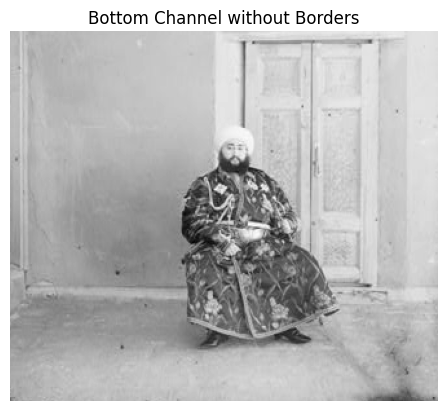

In [93]:
# Remove borders from each channel
top_slice_channel    = remove_borders(top_slice_channel)
middle_slice_channel = remove_borders(middle_slice_channel)
bottom_slice_channel = remove_borders(bottom_slice_channel)

# Display the channels after border removal
for channel, slice in zip([top_slice_channel, middle_slice_channel, bottom_slice_channel], ['Top', 'Middle', 'Bottom']):
    # Create a white canvas slightly larger than the cropped image
    h, w = channel.shape
    # Create a white canvas slightly larger than the cropped image
    padding = 50
    canvas_height = h + 2 * padding
    canvas_width  = w + 2 * padding
    # White canvas
    canvas = np.ones((canvas_height, canvas_width))  

    # Center the cropped image
    start_row = padding
    start_col = padding
    canvas[start_row : start_row + h, start_col : start_col + w] = channel
    
    # Display
    plt.imshow(channel, cmap='gray')
    plt.title(f"{slice} Channel without Borders")
    print(f"{slice} Dimension after border removal on white canvas: {channel.shape}")
    plt.axis('off')
    plt.show()

# Channel Registration